<a href="https://colab.research.google.com/github/elieserDev/Analise_EUR_USD/blob/main/Trader_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install plotly

In [ ]:
# Raw Package
import pandas as pd
import numpy as np

# Data Source
import yfinance as yf

# Data viz
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot


# Trabalhando com Yfinance

In [ ]:
# Download data
df_yf = yf.download(tickers = 'EURUSD=X', period='1d', interval='5m')

In [ ]:
# Processando o Dataframe
df_yf['historical'] = df_yf.index

# Removendo o Index
# df_yf.reset_index(drop=True, inplace=True)

# Criando novas colunas
df_yf['date'] = [d.date() for d in df_yf.index]
df_yf['time'] = [d.time() for d in df_yf.index]
df_yf.drop('historical', axis='columns', inplace=True)

df_yf.head(50)

In [ ]:
# declare figure
fig = go.Figure()

In [ ]:
# Candlestick
fig_f2 = go.Figure(data=[go.Candlestick(x=df_yf.index,
                                        open=df_yf['Open'],
                                        high=df_yf['High'],
                                        low=df_yf['Low'],
                                        close=df_yf['Close'])
                        ])
# Personalizando as cores de alta(increasing) e baixa(decreasing)
fig_f2.data[0].increasing.fillcolor = '#3D9970'
fig_f2.data[0].increasing.line.color = '#3D9970'
fig_f2.data[0].decreasing.fillcolor = '#FF4136'
fig_f2.data[0].decreasing.line.color = '#FF4136'
# Config Layout
fig_f2.update_layout(xaxis_rangeslider_visible=False)

# Add titles
fig_f2.update_layout(
    title='EUR/USD')

# Show
fig_f2.show()

## Criando um Dataframe Com Novas Métricas

A idéia agora é criar uma cópia do dataframe existente e adicionar novas métricas
para identificar padrões e sinais.

Inicialmente, irei criar uma coluna para identificar quais candles são de baixa e
uma outra coluna para identificar quais são os candles de alta.

Assim, posso iniciar a compreender quais são os candles que preciso usar para
encontrar sinais, como por exemplo, a Estrela da Manhã.

A Estrela da Manhã, será o primeiro sinal que irei tentar identificar.
Mas antes, preciso mapear para entender, como será a lógica para identificar os
candles de baixa e alta. A base lógica é a seguinte:


```
candle_de_baixa = abertura > fechamento
candle_de_alta = fechamento > abertura
```

Esta lógica, é baseada na analise visual dos gráficos de candle,
baseado no padrão de cores: Branco(candle de alta) e preto(candle de baixa):
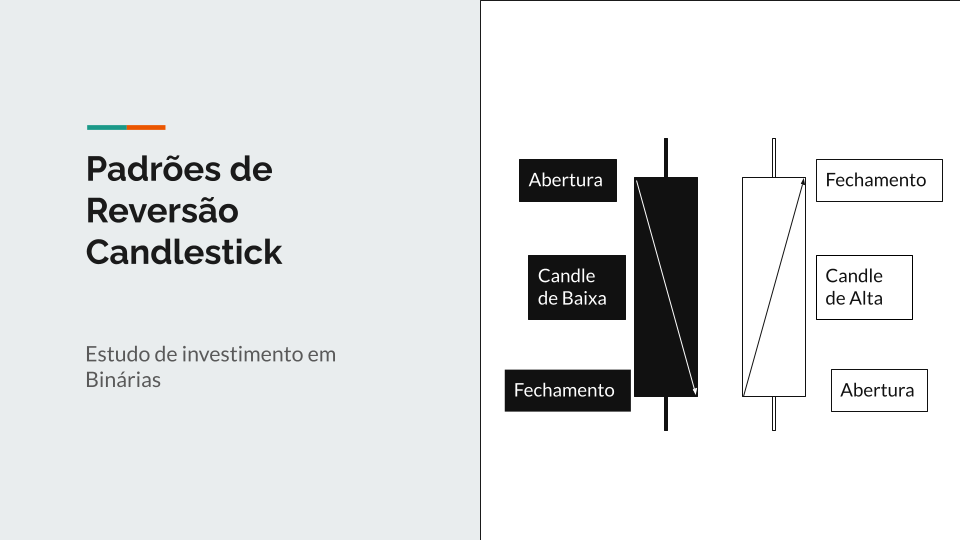


In [ ]:
df_data = df_yf

df_data['body'] = df_data['Close'] - df_data['Open']
df_data['Candle'] = ['high' if x < 0 else 'low' if x > 0 else None for x in df_data['body']]

df_data.head(50)

## Ajustando as cores do Dash
A ideia agora, é normalizar as cores do Dash.
Como existem aberturas e fechamentos iguais a zero, é necessário deixar isso visivel no gráfico. Por exemplo, no estilo de cores verde e vermelhor, o 0x0 deve ser sinalizado como preto.<br><br>

Primeiro, é necessário criar uma coluna de cores, para os respectivos candles:

In [ ]:
#000000 -> Preto
#3D9970 -> verder
#FF4136 -> vermelho
df_data['pallete'] = ['#3D9970' if c == 'high' else '#FF4136' if c == 'low' else '#000000' for c in df_data['Candle']]
df_data.head(50)

Orientações de como personalizar, candles específicos [clicando aqui...](https://community.plotly.com/t/how-do-i-make-special-candles-a-different-color/17223/2)

Logo abaixo, irei pegar os ids referentes aos candles que fecharam como 0x0. Estes ids, devem ser uma lista com cada identificador, para depois ser carregado na construção do dash. <br>Como por exemplo:<br>
highlight_inds = [1, 3]

In [ ]:
df_data['id_candle'] = [x for x in range(len(df_data.index))]
highlight_inds = df_data[pd.isnull(df_data['Candle'])]['id_candle'].tolist()
print('ids dos candles localizados 0x0 -> ', highlight_inds)

### Dash Completo Personalizado

Este é com o período completo. Aqui é uma visualização com todos os candles.
Logo abaixo, o código python para a construção do dash e mais a baixo o dash pronto.

<br>

Porém, podemos perceber que fica bem ruim de visualizar o que realmente está acontecendo. O que parece, é que além dos candles verde e vermelho, também tem candles preto, confundindo a nossa mente.

In [ ]:
# Dados de abertura e fechamento
trace = go.Candlestick(
    x=df_data.index,
    open=df_data['Open'],
    high=df_data['High'],
    low=df_data['Low'],
    close=df_data['Close'],
    name='High/Low'
)

# Dados 0x0
track_highlight = go.Candlestick(
    x=[df_data.index[i] for i in highlight_inds],
    open=[df_data['Open'][i] for i in highlight_inds],
    high=[df_data['High'][i] for i in highlight_inds],
    low=[df_data['Low'][i] for i in highlight_inds],
    close=[df_data['Close'][i] for i in highlight_inds],
    increasing={'line': {'color': 'black'}},
    decreasing={'line': {'color': 'black'}},
    name='None'
)

fig_candlestick = go.Figure(data = [trace, track_highlight])
fig_candlestick.update_layout(xaxis_rangeslider_visible=False)
fig_candlestick.update_layout(
    title='EUR/USD',
    yaxis_title='Price',
    xaxis_title='Timeline')
iplot(fig_candlestick)

Mas, logo vamos aplicar um zoom neste gráfico, para entender o que realmente são estes candles preto.
<br>
Logo, vamos entender que todos os valores que tiveram aberturas e fechamentos iguais, são os respectivos candles preto. Assim, podemos entender que estes candles são exceções que entraram como fechamento 0x0, ou seja, são os nossos valores <code>None</code> da coluna **Candle**.

In [ ]:
iplot(fig_candlestick)